In [1]:
import numpy as np
from igraph import Graph
from tabulate import tabulate
import matplotlib.pyplot as plt
from pysat.solvers import Solver

In [2]:
def toVar(a, b, k):
    return a * k + b + 1

def toColor(var, k):
    return int((var - 1) / k), (var - 1) % k

def exactlyOne(num, k):
    ans = list()
    clauses = list()
    for i in range(k):
        clauses.append(toVar(num, i, k))
    ans.append(clauses)
    for i in range(k):
        for j in range(i + 1, k):
            ans.append([-clauses[i], -clauses[j]])
    return ans

def difColor(a, b, k):
    ans = list()
    for i in range(k):
        ans.append([-toVar(a, i, k), -toVar(b, i, k)])
    return ans       

def MakeSolver(n, k, graph, name):
    solver = Solver(name, use_timer=True)
    for i in range(n):
        solver.append_formula(exactlyOne(i, k))
    for i in range(n):
        for j in range(i + 1, n):
            if graph[i][j]:
                solver.append_formula(difColor(i, j, k))
    return solver           

def writeAns(solver, k):
    ans = list()
    chromN = 0
    colors = np.full(k, -1, int)
    for i in solver.get_model():
        if i > 0:
            ans.append(toColor(i, k))
    ans.sort()
    for i in ans:
        if colors[i[1]] == -1:
            chromN += 1
            colors[i[1]] = chromN
        print(str(colors[i[1]]) + ' ', end='')
    solver.delete()

In [3]:
SAT_graphs = list()
UNSAT_graphs = list()

In [4]:
for i in range(1000):
    n, m, k = 40, 280, 6
    graph = Graph.Erdos_Renyi(n=n, m=m).get_adjacency()
    solver = MakeSolver(n, k, graph, 'g4')
    if solver.solve():
        SAT_graphs.append(graph)
    else:
        UNSAT_graphs.append(graph)
    solver.delete()

In [5]:
SAT_data = list()
UNSAT_data = list()
to_test = min(len(SAT_graphs), len(UNSAT_graphs))
names = ['cadical', 'glucose30', 'glucose41', 'lingeling', 'maplechrono', 
         'maplecm', 'maplesat', 'minicard', 'minisat22', 'minisat-gh']

In [6]:
print(to_test)

421


In [7]:
for name in names:
    time_SAT = list()
    time_UNSAT = list()
    for i in range(to_test):
        solver = MakeSolver(n, k, SAT_graphs[i], name)
        solver.solve()
        time_SAT.append(solver.time())
        solver.delete()
    for i in range(to_test):
        solver = MakeSolver(n, k, UNSAT_graphs[i], name)
        solver.solve()
        time_UNSAT.append(solver.time())
        solver.delete()
    SAT_data.append([np.mean(time_SAT), np.std(time_SAT)])
    UNSAT_data.append([np.mean(time_UNSAT), np.std(time_UNSAT)])

In [8]:
SAT_std = list()
SAT_time = list()
UNSAT_std = list()
UNSAT_time = list()
headers = ['Solver name', 'Avg. SAT time ms.', 'Std.', 'Avg. UNSAT time sec.', 'Std.']

In [9]:
for i in range(len(names)):
    SAT_std.append(round(SAT_data[i][1] * 1000, 2))
    SAT_time.append(round(SAT_data[i][0] * 1000, 2))
    UNSAT_std.append(round(UNSAT_data[i][1], 2))
    UNSAT_time.append(round(UNSAT_data[i][0], 2))

In [10]:
table = zip(names, SAT_time, SAT_std, UNSAT_time, UNSAT_std)

In [11]:
print(tabulate(table, headers, 'github'))

| Solver name   |   Avg. SAT time ms. |    Std. |   Avg. UNSAT time sec. |   Std. |
|---------------|---------------------|---------|------------------------|--------|
| cadical       |               13.13 |   17.94 |                   2.03 |   2.34 |
| glucose30     |                9.13 |   12.08 |                   2.95 |   3.91 |
| glucose41     |                9.19 |   12.28 |                   2.23 |   2.5  |
| lingeling     |               20.74 |   33.64 |                  14.56 |  17.56 |
| maplechrono   |             2930.46 | 2980.02 |                  14.72 |   7.15 |
| maplecm       |               10.83 |   13.34 |                   5.15 |   5.9  |
| maplesat      |               15    |   21.35 |                   3.02 |   3.32 |
| minicard      |                1.86 |    2.65 |                   1.03 |   1.31 |
| minisat22     |                1.81 |    2.57 |                   1    |   1.28 |
| minisat-gh    |                1.75 |    2.52 |                   0.99 |  

In [12]:
SAT_y = list(SAT_data[i][0] for i in range(len(names)))
SAT_err = list(SAT_data[i][1] for i in range(len(names)))
UNSAT_y = list(UNSAT_data[i][0] for i in range(len(names)))
UNSAT_err = list(UNSAT_data[i][1] for i in range(len(names)))

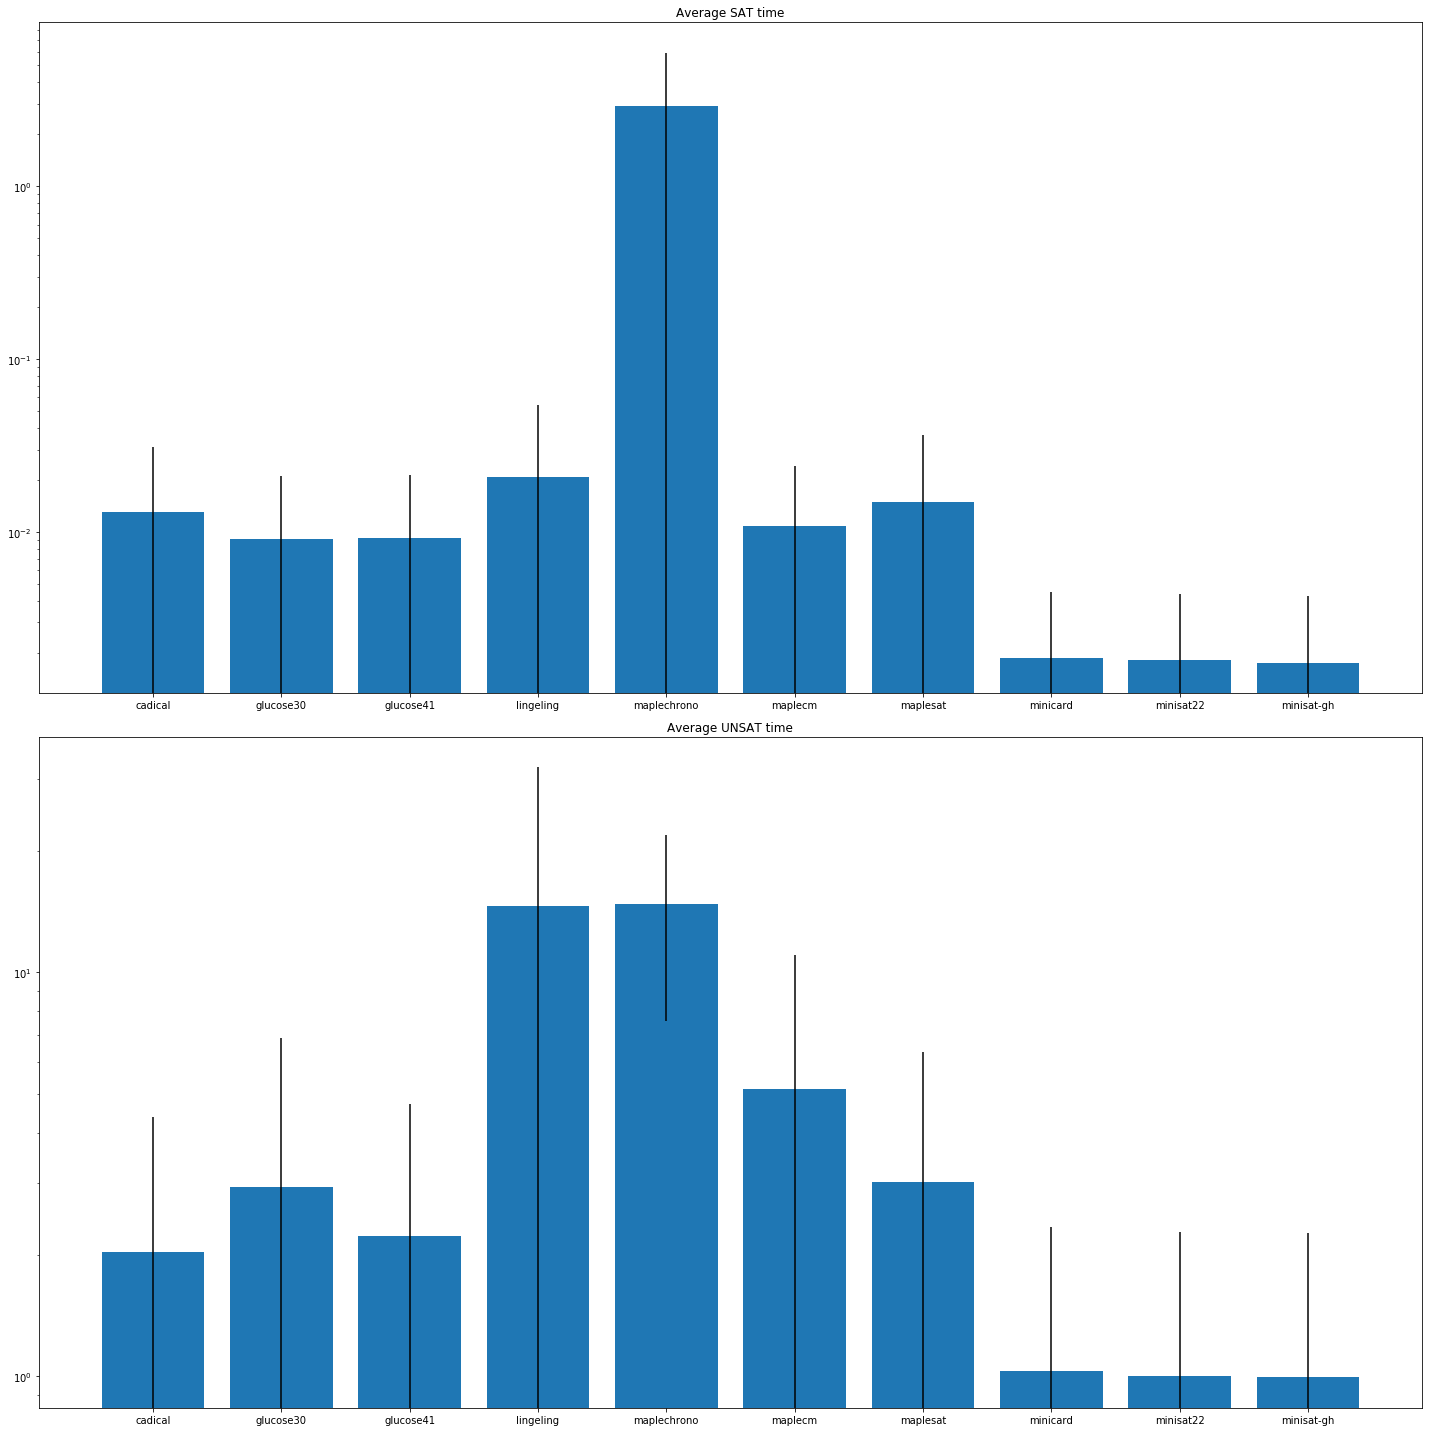

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
ax1.set_title('Average SAT time')
ax2.set_title('Average UNSAT time')
ax1.bar(names, SAT_y, yerr=SAT_err, log=True)
ax2.bar(names, UNSAT_y, yerr=UNSAT_err, log=True)
plt.tight_layout()

In [14]:
# В обоих тестах minisat и minicard работают в 2-4 раза быстрее ближайших конкурентов.